In [1]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import FloRodMethods as frm
import time

%matplotlib inline

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
#useful tool for seeing which day of the year marks the beginning of various months
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]
DAYS_SUM

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

In [4]:
df = load_region('C:/Users/DJFRO/Hubs/Clustering/county1000.csv')

In [5]:
df

,194565,22533,280581,10250,118794,225290,243737,159770,311322,323609,...,24549,282597,124905,120810,12266,215017,278506,8169,149497,249854
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,27.90,9.260,4.000,7.610,4.490,20.80,2.271,34.06,4.406,4.520,...,1.214,0.4448,1.1320,12.625,6.137,1.201,24.60,3.834,5.586,2.172
2018-01-01 00:30:00,31.20,9.266,3.973,7.613,4.490,20.81,2.488,32.60,4.402,4.520,...,1.203,0.3374,1.2440,12.550,6.082,1.201,23.97,3.800,5.360,2.172
2018-01-01 00:45:00,27.67,9.280,3.895,7.620,4.490,20.81,2.396,31.64,4.290,4.520,...,1.141,0.3403,0.9910,12.440,6.040,1.201,23.94,3.684,5.273,2.172
2018-01-01 01:00:00,27.66,9.305,3.852,7.630,4.490,20.83,2.162,30.97,4.230,4.520,...,1.606,0.3152,0.9893,12.375,5.543,1.201,23.95,3.710,5.200,2.172
2018-01-01 01:15:00,28.17,28.530,3.871,23.530,4.594,31.47,2.658,26.61,4.020,13.370,...,4.150,2.3520,1.4750,13.400,6.387,5.970,32.56,3.258,5.125,2.428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,29.17,9.195,4.270,7.550,4.490,21.38,2.164,44.47,4.610,4.523,...,2.035,0.5140,0.7275,16.890,6.240,1.201,24.40,4.070,7.510,2.172
2018-12-31 23:15:00,28.78,9.195,4.130,7.566,4.490,21.27,2.420,41.50,4.492,4.523,...,1.847,0.5273,0.9795,13.090,6.230,1.201,24.00,3.992,6.926,2.172
2018-12-31 23:30:00,28.58,9.220,4.086,7.580,4.490,21.20,2.484,39.70,4.450,4.523,...,1.624,0.5454,0.9480,13.016,6.227,1.201,24.05,3.941,6.598,2.172


In [6]:
clusters = np.load('kmeans112.npy')

In [7]:
data = np.asarray(df[DAYS_SUM[5]*24*4:DAYS_SUM[8]*24*4]).astype('float16').T
#only rows corresponding to june through august, and transposing it in the form of an array

In [8]:
blds, t_len = data.shape

In [9]:
num_days = t_len//(24*4)
num_days

92

In [10]:
data_days = data.reshape(blds,num_days,24*4)
#tensor of blds, by days, by daily measurements

In [11]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)
#similar as above but now it's two day blocks, s.t. we have day 0 through 1, 1 through 2, etc.

## Choosing a cluster

In [12]:
c = 71

In [13]:
blds_in_c = np.squeeze(np.argwhere((clusters==71).astype(int)))
print('cluster: ',c,' \nhas buildings: ',blds_in_c)
blds_tst =  blds_in_c[[1,4,8]]
print('we choose: ',blds_tst)


cluster:  71  
has buildings:  [ 128  148  282  362  699  801  834 1001 1064]
we choose:  [ 148  699 1064]


Building  128  in cluster  71


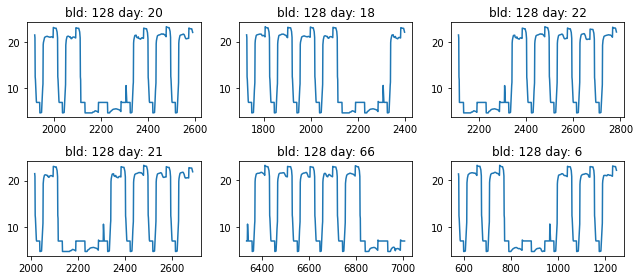



Building  148  in cluster  71


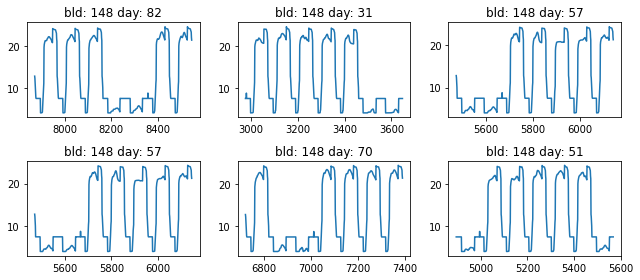



Building  282  in cluster  71


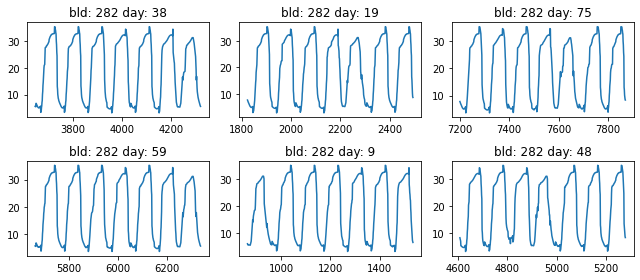



Building  362  in cluster  71


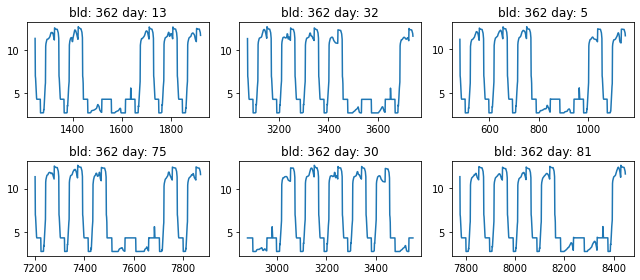



Building  699  in cluster  71


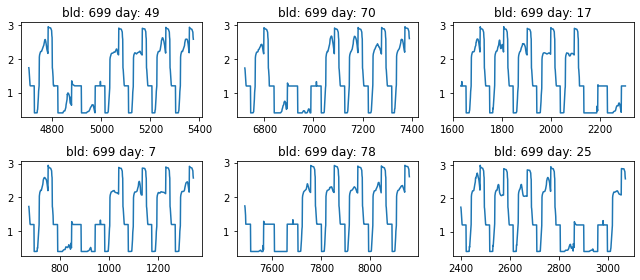



Building  801  in cluster  71


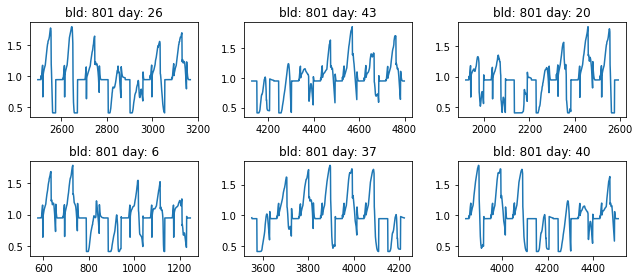



Building  834  in cluster  71


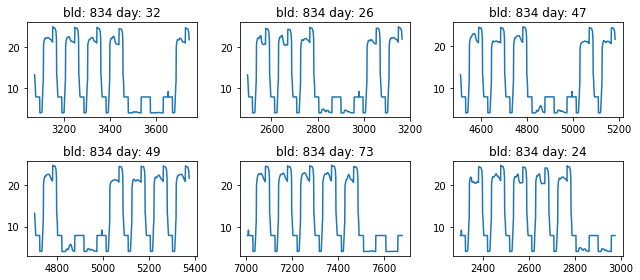



Building  1001  in cluster  71


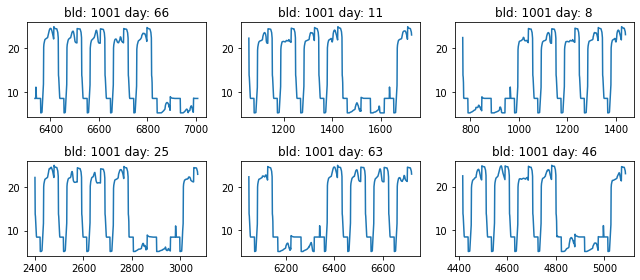



Building  1064  in cluster  71


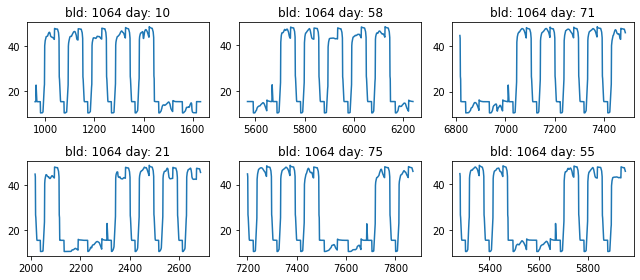

In [14]:
#data analysis
for j in blds_in_c:
    print('Building ',j,' in cluster ',c)
    plt.subplots(2,3, figsize = (9,4))
    bld = j
    for i in range(6):
        plt.subplot(2,3,i+1)
        day = np.random.randint(0,num_days-8)
        plt.plot(np.arange(day*24*4,(day+7)*24*4),data[bld,day*24*4:(day+7)*24*4])
        plt.title('bld: '+str(bld)+ ' day: '+str(day))
    plt.tight_layout()
    plt.show()
    print('\n')

In [15]:
xs = {}
for bld in blds_in_c:
    x,y = frm.splitSeqs(data[bld],14*24*4,24*4)
    #generates x y pairs of sequential data with inputs of two weeks and a day output
    #but it's raw data, which isn't too useful alone (some 7300 datapoints made per
    #building)
    xs['x'+str(bld)] = x
    xs['y'+str(bld)] = y

In [16]:
x,y = xs['x128'],xs['y128']

## Now we'll extract weekdays and normalize the data

In [17]:
dataWeeks = data[128,:91*24*4].reshape(-1,7*24*4)

In [18]:
def showRandRows(M,N=None,leg=False):
    '''
    function to sample rows from a matrix M, returns the N rows chosen if 'leg' 
    it will add legend to the plot
    '''
    if N==None:
        N = M.shape[0]
    randRows  =np.random.choice(M.shape[0],size=N,replace=False)
    for i in randRows:
        plt.plot(M[i])
    if leg:
        pl.legend(randRows)
    return randRows

array([ 1, 12,  3,  8,  6,  2,  5,  9,  7,  4, 11,  0, 10])

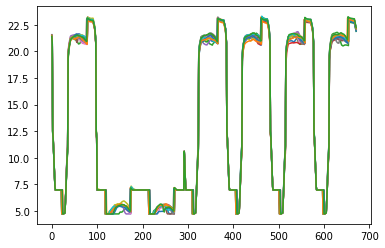

In [19]:
showRandRows(dataWeeks)
#this adds, up, he first day of June 2018 was a friday, so we'll remove sat and sun

In [20]:
weekdays = np.concatenate([dataWeeks[:,:24*4],dataWeeks[:,24*4*3:]],axis=1)

array([ 7, 11,  3,  1,  2,  4, 12,  0,  5,  6])

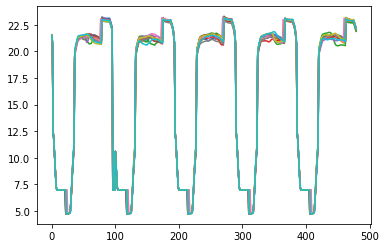

In [21]:
showRandRows(weekdays,10)

In [22]:
x,y = frm.splitSeqs(weekdays.reshape(-1),1,24*4)

In [23]:
y.shape

(6144, 96)

array([2007, 2530, 3659, 1395, 4442, 1625, 1009, 2332, 4039, 4172, 3763,
       2235,  922, 3668, 4550, 3957, 5553, 4287, 4582, 2445])

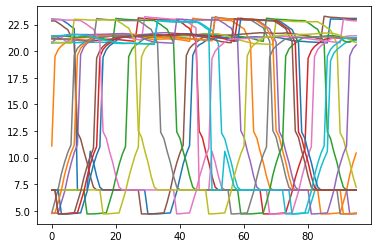

In [24]:
showRandRows(y,20)

In [25]:
yn = (y-np.mean(y,axis=1,keepdims=True))/np.std(y,axis=1,keepdims=True)

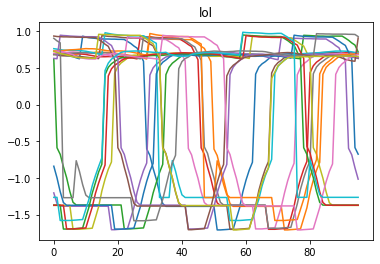

In [26]:
showRandRows(yn,20)
plt.title('lol');

In [27]:
x_input = np.random.randn(12,4)


In [28]:
def dispRandRows(M, N,figsize=(6,3)):
    '''
    plots N2 rows in an array N2/4 by 4 of individual plots, where N2 is the smallest multiple
    of 4 equal to or greater than N.
    plots contain random rows of matrix M
    '''
    N2 = (N//4+1)*4
    randRows  =np.random.choice(M.shape[0],size=N2,replace=False)
    plt.subplots(N2//4,4,figsize=figsize)
    for i in range(N2):
        plt.subplot(N2//4,4,i+1)
        plt.plot(M[i])
    plt.tight_layout()


In [29]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# x,y = xs['x128'],xs['y128']
 
# testx = np.random.randn(10000,1)*8
# testy = (testx+3)**2-1
# testdata = np.zeros((10000,2))
# testdata[:,0] = testx.reshape(10000)
# testdata[:,1] = testy.reshape(10000)

# define the standalone discriminator model
def define_discriminator(n_inputs=24*4):
    model = Sequential()
    model.add(Dense(24*2, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(18, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=24*4):
    model = Sequential()
    model.add(Dense(16, activation='tanh', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(24, activation='tanh', kernel_initializer='he_uniform'))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate n real samples with class labels
def generate_real_samples(x,n):
    # generate inputs in [-0.5, 0.5]
    np.random.shuffle(x)

    X = x[:n,:]
    # generate class labels
    y = ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    #made a method to allow future editing
    return np.random.randn(n,latent_dim)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=20,M=x):
    # prepare real samples
    x_real, y_real = generate_real_samples(M,n)
    
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    print('xreal ',x_real.shape, 'x_fake' ,x_fake.shape)
    # scatter plot real and fake data points
    #     row = np.random.randint(n)

    #     pyplot.scatter(x_real[:,0],x_real[:,1], color='red')
    dispRandRows(x_real,12)
    plt.title('real');
    plt.show()
    #pyplot.scatter(x_fake[:,0],x_fake[:,1], color='blue')
    dispRandRows(x_fake,12)
    pyplot.title('fake')
    pyplot.show()
    return

# train the generator and discriminator

def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=100,M=None):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    t0 = time.time()
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(M,half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i) % n_eval == 0 or i+1==n_epochs:
            summarize_performance(i, g_model, d_model, latent_dim,M=M)
            dt = time.time()-t0
            
            print("We're doing about ", dt*n_eval//((i+1)*60), ' min per ',n_eval ,' epochs')
    return
# size of the latent space
# latent_dim = 16
# # create the discriminator
# discriminator = define_discriminator(n_inputs=24*4)
# # create the generator
# generator = define_generator(latent_dim, n_outputs =24*4)
# # create the gan
# gan_model = define_gan(generator, discriminator)
# # train model
# train(generator, discriminator, gan_model, latent_dim,M=yn, n_epochs=10000,n_eval=2000)

0 0.949999988079071 0.10000000149011612
xreal  (20, 96) x_fake (20, 96)


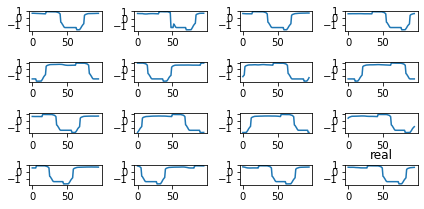

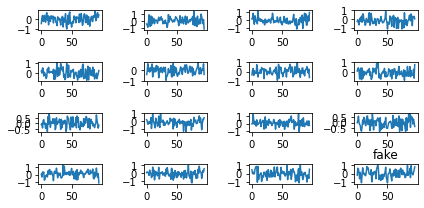

We're doing about  727.0  min per  2000  epochs
2000 0.8999999761581421 1.0
xreal  (20, 96) x_fake (20, 96)


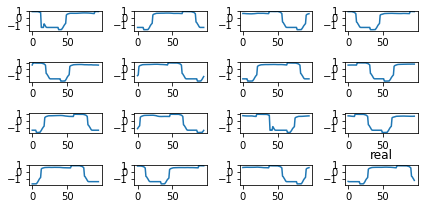

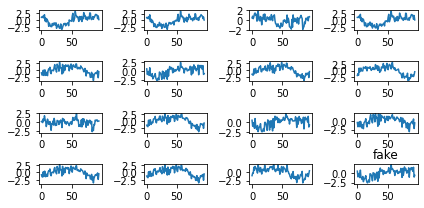

We're doing about  2.0  min per  2000  epochs
4000 0.800000011920929 0.949999988079071
xreal  (20, 96) x_fake (20, 96)


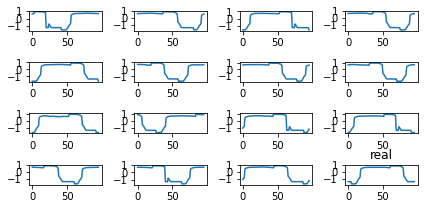

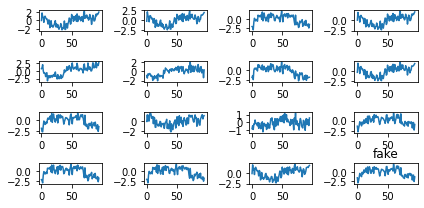

We're doing about  2.0  min per  2000  epochs
6000 0.8999999761581421 1.0
xreal  (20, 96) x_fake (20, 96)


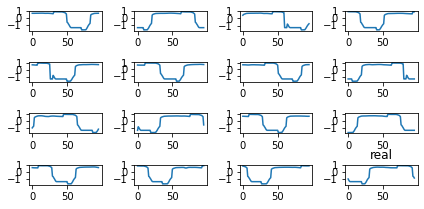

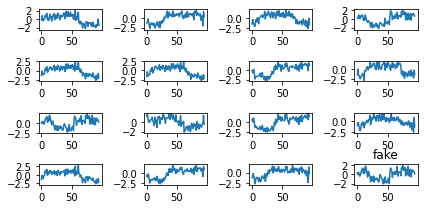

We're doing about  2.0  min per  2000  epochs
8000 0.800000011920929 0.800000011920929
xreal  (20, 96) x_fake (20, 96)


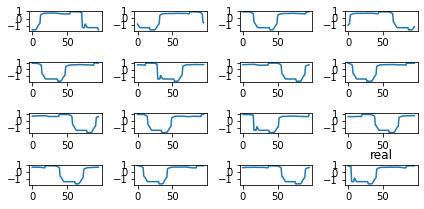

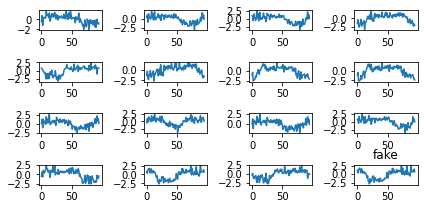

We're doing about  2.0  min per  2000  epochs
9999 0.8500000238418579 0.8999999761581421
xreal  (20, 96) x_fake (20, 96)


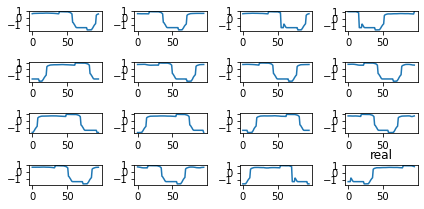

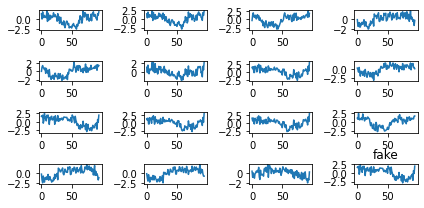

We're doing about  2.0  min per  2000  epochs


In [30]:

# size of the latent space
latent_dim = 16
# create the discriminator
discriminator = define_discriminator(n_inputs=24*4)
# create the generator
generator = define_generator(latent_dim, n_outputs =24*4)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim,M=yn, n_epochs=10000,n_eval=2000)